<h1>MLE of aDDM in Krajbich, Armel, Rangel (KAR) 2010 (using data from Smith)</h1>

In the paper they compare three models: Model 1, the regular DDM given by the case of θ = 1; Model 2, a DDM with full fixation bias given by the case of θ = 0; Model 3, a DDM with partial fixation bias given by the case 0 < θ < 1.

Experiment: In the first stage subjects rated how much they would like to eat 70 food items (147 items in Smith and Krajbich 2019) at the end of the experiment (scale −10 to 10). The liking ratings provide an independent measure of the value of individual items. In the second stage subjects made 100 choices between pairs of neutral or appetitive foods. Afterwards they ate the item chosen in a randomly selected trial. 

Measurements at 50Hz (=50 datapoints in a second).

Model fitted to the even-numbered trials of the group data using maximum likelihood estimation (MLE) on the observed choices and reaction times.

<h2>Dataset 2 from Smith</h2>
<p>The below is dataset ACADchoiceandeyedata. It has 44 subjects and 147 food items, so it is the Dataset 2 from Smith and Krajbich (2019) page 118.</p>

In [2]:
data<-load("ACADchoiceandeyedata.RData")
#data<-load("ACADratingdata.RData")
head(data)

[1] "twofoodchoicedata"   "foodriskchoicedata"  "moneyriskchoicedata"
[4] "socialchoicedata"    "twofoodeyedata"      "foodriskeyedata"

<p>We shall use the dataframe 'twofoodchoicedata'. There the interesting variables are reaction times (RT), choices (LeftRight, 1=left, 2=right), subject and trial numbers. Only even-numbered trials are analysed, this is (probably) to reduce the effect of autocorrelation in repeated choices.</p>

<h2>Simulated reaction times from aDDM of KAR2010</h2>
<p>The below function returns a simulated RT as function of choice, d, theta, and sigma, which are parameters of the aDDM model.</p><p>Note that it does not assume a gaze process, but only a drift that will lead to choice when the barrier indicated by that choice is exceeded.</p>

In [3]:
# this function returns RT as function of the choice, d, theta, and sigma

addm <- function(choice,d,th,sigma) {

    # choice is given by the LeftRight variable
    
    # assume that starts in the middle; therefore RT = time it takes for the process to drift towards choice
    rR <- 1
    rL <- 1

    V <- c()
    V <- c(V,0)

    t <- 2
    while (abs(V[t-1]) < .5) {

        if (choice==1) { 
            drift <- d*(rL - th*rR)  # drifting left
        } 
        else {
            drift <- -d*(rR - th*rL) # drifting right        
        }

        V <- c(V, V[t-1] + drift + rnorm(1, mean = 0, sd = sigma))    

        t <- t + 1
    }

    RT = length(V)/60
    return(RT)
}


<p>The below function creates a list of simulated RTs that has the same size as twofoodchoicedata$RT.</p>

In [4]:
RTsimulate <- function(d,th,sigma) {
    simRT <- c()
    for (i in 1:length(twofoodchoicedata$RT)) { 
        simRT <- c(simRT,addm(twofoodchoicedata$LeftRight[i],d,th,sigma)) 
    }
    return(simRT)
}

<p>Now we create a dataframe that has subject and trial identifiers and the real and simulated RT data.</p>

In [8]:
createRTdf <- function(karDF,d,th,sigma) {
    twofoodchoicedata <- karDF
    RTdf <- data.frame(
        subject=twofoodchoicedata$SubjectNumber, 
        trial=twofoodchoicedata$Trial, 
        realRT=twofoodchoicedata$RT, 
        simRT=RTsimulate(d,th,sigma)) # d=.009, th=.3, sigma=.02

    # subset to even numbered trials
    RTdf$eventrial <- ifelse(RTdf$trial%%2==0,1,0)
    RTdf <- subset(RTdf, eventrial==1)

    # reshape wide to long to allow easy plotting with ggplot
    library(reshape2)
    RTdf <- melt(RTdf, id.vars=c("subject", "trial", "eventrial"), variable.name="RTtype")
    
    return(RTdf)
}

<p>Plot the real and simulated RTs together to see for which parameter values they fit. It seems that theta should be considerably larger than in KAR2010.</p>

Warning message:
“Removed 4 rows containing non-finite values (stat_density).”

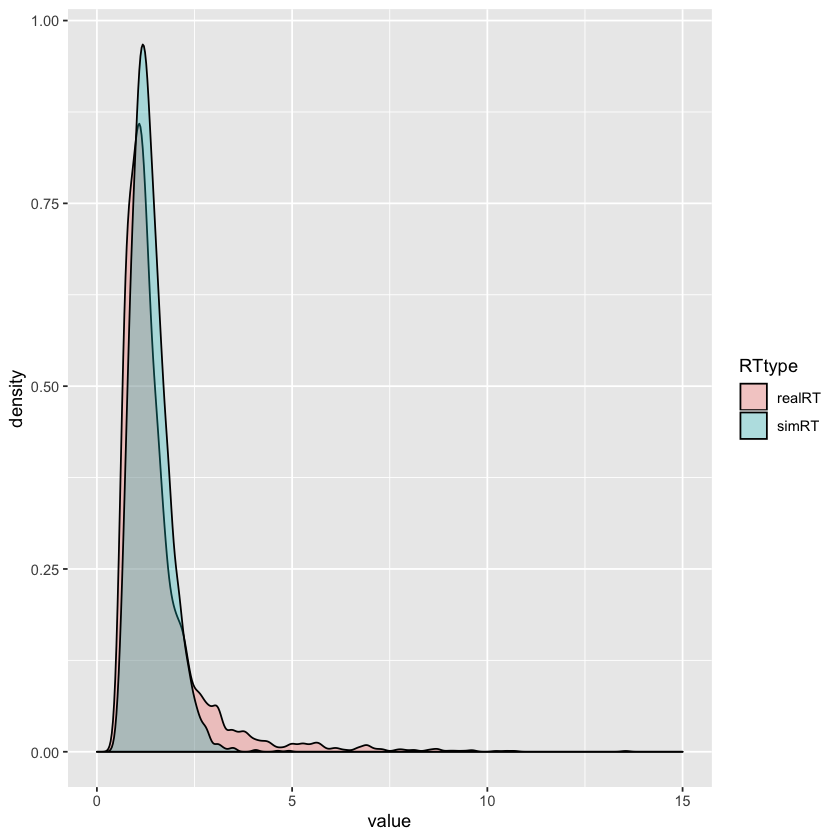

In [10]:
# these are the best fitting values according to KAR2010: d=0.0002, th=.3, sigma=.02
# these give better fit however: d=.009, th=.3, sigma=.02

library(ggplot2)
plottingdf <- createRTdf(twofoodchoicedata,.009,.3,.02)
ggplot(plottingdf, aes(x=value, fill=RTtype)) + geom_density(alpha=.3) + xlim(0,15)

<h2>MLE</h2>
<p>The below outputs the likelihood function on the RTs, assuming that real RT = simulated RT + residual</p>

In [11]:
# Likelihood function assuming model RT = simRT + residual
LL <- function(d,th,sigma) {
    RT <- twofoodchoicedata$RT
    simRT <- c()
    for (i in 1:length(twofoodchoicedata$RT)) { 
        simRT <- c(simRT,addm(twofoodchoicedata$LeftRight[i],d,th,sigma)) 
    }
    return(-sum(log(abs(RT-simRT))))
}

In [46]:
# d=0.0002, th=.3, sigma=.02
c(LL(.0002,.3,.02),LL(.009,.3,.02),LL(.005,.3,.02))

[1] -70455.926  -5973.175 -10782.929

<p><a href="https://www.r-bloggers.com/fitting-a-model-by-maximum-likelihood/">https://www.r-bloggers.com/fitting-a-model-by-maximum-likelihood/</a></p>

In [55]:
# THIS DOES NOT CURRENTLY WORK, OR TAKES TOO LONG TO COMPUTE
library(bbmle)
summary(mle2(LL, 
             start = list(d=0.0002, th=.3, sigma=.02), 
             method = "L-BFGS-B", 
             lower = c(d=0.0001,th=0.01,sigma=0), 
             upper = c(d=.01,th=.99,sigma=Inf)))#, nobs = length(q))

